In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split #для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [2]:
hotels = pd.read_csv('hotels.csv')

In [3]:
#вытаскиваем все данные из даты и убираем лишнее
hotels['review_date']=pd.to_datetime(hotels['review_date'])
hotels['review_year']=pd.to_datetime(hotels['review_date']).dt.year
hotels['review_month']=pd.to_datetime(hotels['review_date']).dt.month
hotels['review_day']=pd.to_datetime(hotels['review_date']).dt.day
hotels['review_day_of_week']=pd.to_datetime(hotels['review_date']).dt.day_of_week
del hotels['review_date']

# столбцы с отсутствующими значениями
are_columns_null=dict((hotels.isnull().mean()>0))
cols_with_null=[x for x in are_columns_null if are_columns_null[x]==True]
cols_with_null

['lat', 'lng']

Заполним пустующие признаки модальными значениями и добавим признак, демонстрирующий, что признак был пустым.

In [4]:
for i in cols_with_null:
    hotels[i+'_was_null']=hotels[i].isnull()
    
values={'lat':hotels['lat'].mode()[0],
        'lng':hotels['lng'].mode()[0]}
hotels=hotels.fillna(values)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   average_score                               386803 non-null  float64
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  object 
 6   review_total_negative_word_counts           386803 non-null  int64  
 7   total_number_of_reviews                     386803 non-null  int64  
 8   positive_review                             386803 non-null  object 
 9   review_total_positive_word_counts           386803 non-null  int64  
 

C:\Users\user\AppData\Local\Temp\ipykernel_6096\1424477258.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.corr(),


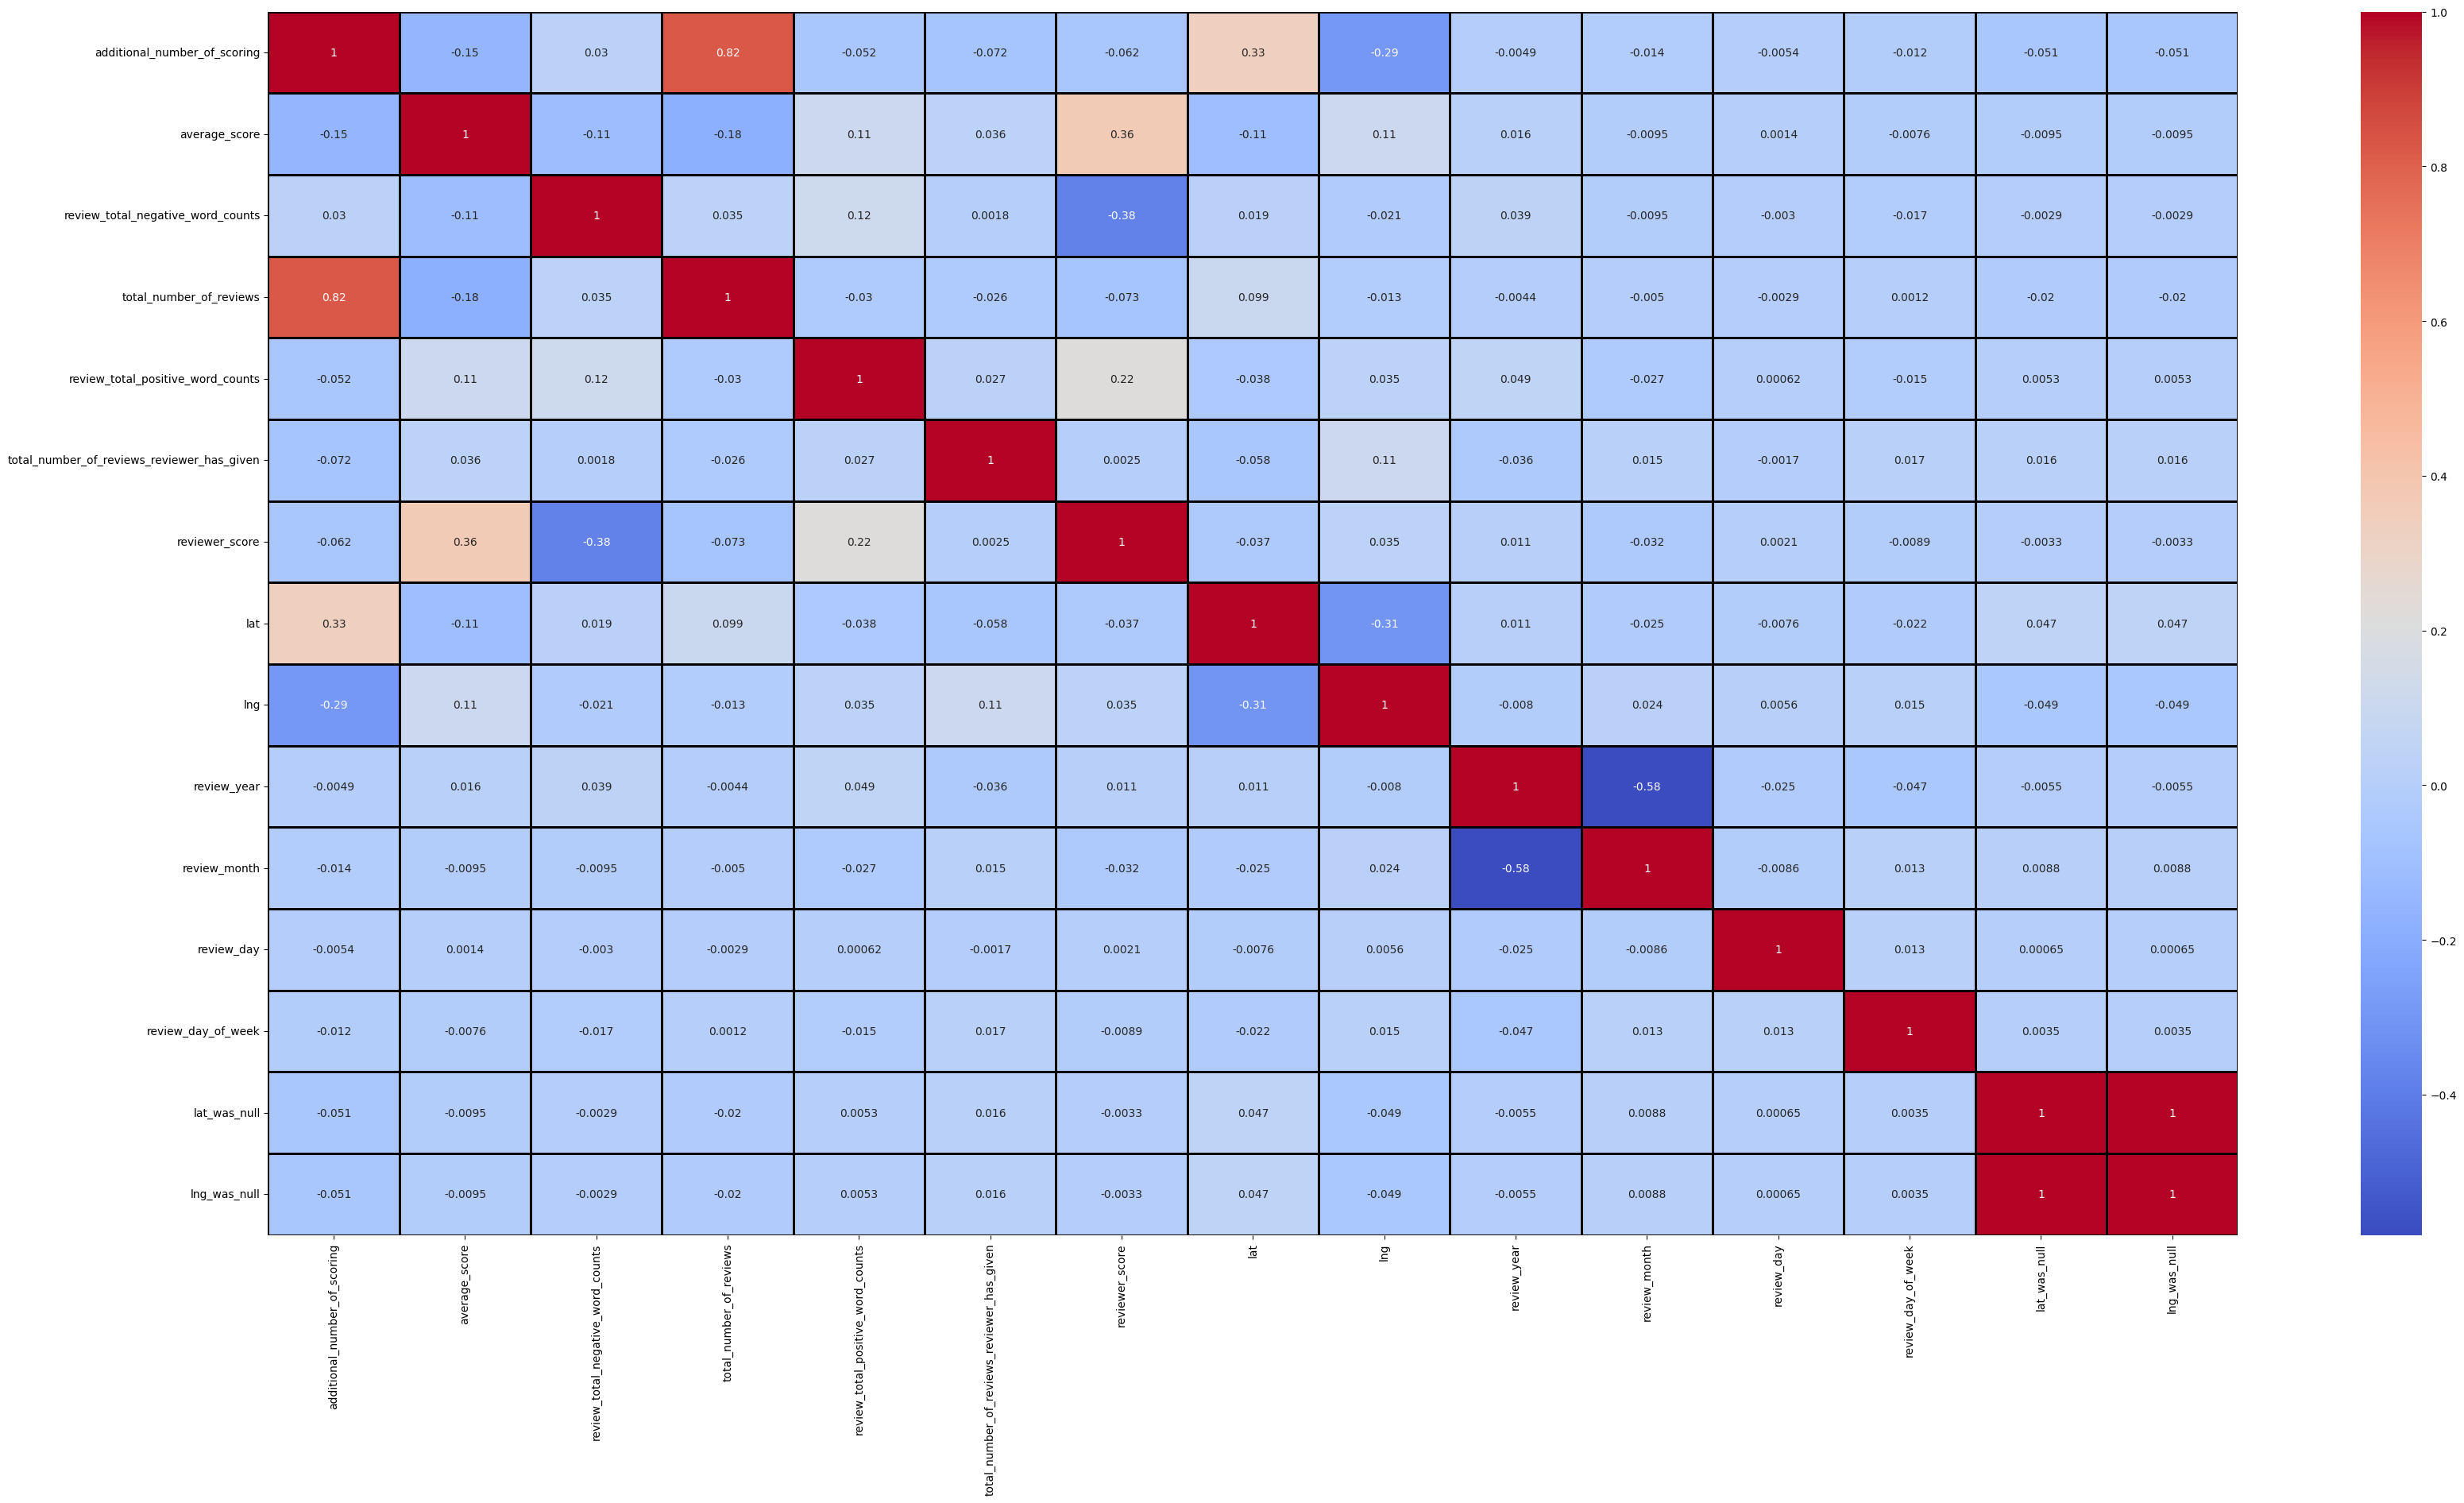

In [5]:
fig,ax=plt.subplots(figsize=(40,20))
sns.heatmap(hotels.corr(),
            annot=True,
            linewidths=0.75,
            linecolor='black',
            cmap='coolwarm');

По таблице корреляции видно, что столбцы lat_was_null и lng_was_null мультиколлинеарны. Очевидно, что данные lat и lng не были заполнены в одних и тех же местах, поэтому удалим один.

In [6]:
hotels=hotels.drop('lng_was_null',axis=1)

Перекодируем всю информацию для комфортной работы RandomForest

In [7]:
#из адреса вытаскиваем страну и удаляем строковый адрес отеля
def find_country(arg:str)->str:
    '''
    - принимает адрес отеля
    - отдает страну отеля
    '''
    
    arg=arg.replace("'",'')
    arg=arg.split()
    if arg[-2:]==['United', 'Kingdom']:
        return 'United Kingdom'
    arg=arg[-1]
    return arg

hotels['hotel_country']=hotels['hotel_address'].apply(find_country)

del hotels['hotel_address']

#кодируем колонку hotel_country и и удаляем
encoder=ce.OneHotEncoder(
    cols=['hotel_country'],
    use_cat_names=True
)
type_bin=encoder.fit_transform(hotels['hotel_country'])
hotels=pd.concat([hotels,type_bin], axis=1)
del hotels['hotel_country']

# закодируем hotel_name бинарным кодированием для экономии столбцов (значений более 1000)
bin_encoder=ce.BinaryEncoder(cols=['hotel_name'])
type_bin=bin_encoder.fit_transform(hotels['hotel_name'])
hotels=pd.concat([hotels,type_bin],axis=1)
del hotels['hotel_name']

#закодируем reviewer_nationality также двоичным кодированием (225 столбцов)
bin_encoder=ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin=bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels=pd.concat([hotels,type_bin],axis=1)
del hotels['reviewer_nationality']

# столбец review_total_negative_word_counts по мне был неверен и был скрректирован
def negative_owd_counts_function(arg):
    if arg=='No Negative':
        return 0
    return len(arg.split())

hotels['review_total_negative_word_counts']=hotels['negative_review'].apply(negative_owd_counts_function)
del hotels['negative_review']

# столбец review_total_positive_word_counts по мне был неверен и был скрректирован
def positive_word_counts_function(arg):
    if arg=='No Positive':
        return 0
    return len(arg.split())

hotels['review_total_positive_word_counts']=hotels['positive_review'].apply(positive_word_counts_function)
del hotels['positive_review']

#оставляем в столбце только количествво дней и переводим в тип int64
hotels['days_since_review']=hotels['days_since_review'].apply(lambda x: x.split()[0])
hotels['days_since_review']=hotels['days_since_review'].astype('int64')

def clean_column(arg):
    arg=arg.replace("[","")
    arg=arg.replace("]","")
    arg=arg.replace("' ","")
    arg=arg.replace(" '","")
    arg=arg.split(',')
    return arg

hotels['tags']=hotels['tags'].apply(clean_column)

#уменьшим размер таблицы
columns_list=[x for x in hotels if hotels[x].dtypes=='int64']
for i in columns_list:
    if hotels[i].min()>=-128 and hotels[i].max()<=127:
        hotels[i]=hotels[i].astype('int8')
    elif hotels[i].min()>=-32768 and hotels[i].max()<=32767:
        hotels[i]=hotels[i].astype('int16')

hotels.head(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,581,8.4,1,1994,3,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed...",531,51.507894,...,0,1,0,0,0,0,0,0,0,1
1,299,8.3,2,1361,1,14,6.3,"[Business trip, Couple, Standard Double Room...",203,51.521009,...,1,0,0,0,0,0,0,0,0,1


In [8]:
def find_leisure_trip(arg):
    '''найдет тип поездки - досуг'''
    for i in arg:
        if i=='Leisure trip':
            return 1
    return 0
hotels['Leisure trip']=hotels['tags'].apply(find_leisure_trip)

def find_business_trip(arg):
    '''найдет тип поездки - бизнес'''
    for i in arg:
        if i=='Business trip':
            return 1
    return 0
hotels['Business trip']=hotels['tags'].apply(find_business_trip)

def stayed_nights_count(arg):
    '''найдет на сколько ночей остался посетитель'''
    for i in arg:
        x=i.split(' ')
        for j,k in enumerate(x):
            if k=='Stayed':
                return x[j+1]
hotels['Stayed nights']=hotels['tags'].apply(stayed_nights_count)

hotels['Stayed nights']=hotels['Stayed nights'].fillna(hotels['Stayed nights'].median()) #заполняем недостающие значения

def mobile_f(arg):
    '''отправлен ли отзыв с мобильного устройства'''
    for i in arg:
        if (i==' Submitted from a mobile device' or i=='Submitted from a mobile device'):
            return 1
    return 0
hotels['Submitted from a mobile device']=hotels['tags'].apply(mobile_f)




Вытащим из тегов тип посетителя

In [9]:
def couple_f(arg):
    '''гостя 2'''
    for i in arg:
        i=i.replace(' ','')
        if i=='Couple':
            return 1
    return 0
hotels['Couple']=hotels['tags'].apply(couple_f)

def solo_f(arg):
    '''гостя 2'''
    for i in arg:
        if i==' Solo traveler':
            return 1
    return 0
hotels['Solo traveler']=hotels['tags'].apply(solo_f)

def fam_f(arg):
    '''семья с маленьким ребенком'''
    for i in arg:
        if i==' Family with young children':
            return 1
    return 0
hotels['Family with young children']=hotels['tags'].apply(fam_f)

def group_f(arg):
    '''группа'''
    for i in arg:
        if i==' Group':
            return 1
    return 0
hotels['Group']=hotels['tags'].apply(group_f)

del hotels['tags']

In [10]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [12]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [20]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'Итого: показатель Mean Absolute Percentage Error (MAPE) {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100,2)} %')

Итого: показатель Mean Absolute Percentage Error (MAPE) 13.56 %
